<a href="https://colab.research.google.com/github/JuanARojasA/Ciencia_Datos/blob/master/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Para realizar un entrenamiento rápido del proyecto, desde Google Cola, se recomienda asignar el acelerador de Hardware por GPU
Editar->Configuración de Notebook->Acelerador de Hardware->GPU

Se accede al GDrive para importar desde este el repositorio en GitHub en donde se encuentran las imagenes de entrenamiento, validación y prueba

In [15]:
from google.colab import drive
drive.mount('/content/drive')

# Esta linea se usa para importar el repositorio de Github
!git clone https://github.com/JuanARojasA/Ciencia_Datos.git
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'Ciencia_Datos' already exists and is not an empty directory.
Ciencia_Datos  drive  sample_data


In [0]:
from tensorflow.keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import load_model
from keras.models import Model
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
import numpy as np


# Librería para graficar 
import matplotlib.pyplot as plt
from scipy import interp
from itertools import cycle
import itertools

# Librerías para obtener métricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

Se crea un string con la ruta de acceso a cada conjunto de datos del dataset

In [0]:
ruta_dataset_entrenamiento = "/content/Ciencia_Datos/EjemploCNN/training"
ruta_dataset_prueba = "/content/Ciencia_Datos/EjemploCNN/test"
ruta_dataset_validacion = "/content/Ciencia_Datos/EjemploCNN/validation"
num_classes = 3

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [19]:
train_generator = train_datagen.flow_from_directory(ruta_dataset_entrenamiento,target_size=(224,224),color_mode='rgb',batch_size=32,class_mode='categorical',shuffle=True)
test_generator = test_datagen.flow_from_directory(ruta_dataset_prueba,target_size=(224,224),color_mode='rgb',batch_size=1,class_mode='categorical',shuffle=False)
validation_generator = validation_datagen.flow_from_directory(ruta_dataset_validacion,target_size=(224,224),color_mode='rgb',batch_size=32,class_mode='categorical',shuffle=True)

Found 1540 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 360 images belonging to 3 classes.


Se importa la CNN pre-entrenada VGG16 con los pesos del entrenamiento usado con el Dataset 'imagenet' el cual posee 1000 clases de clasificación.

In [20]:
vgg16 = VGG16(weights='imagenet')
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Debido a que la salida de la CNN VGG16 posee 1000 clases, es necesario modificar esto, para que funcione unicamente con 3 salidas, ya que al realizar el proceso de entrenamiento, prueba y validación, se generan inconvenientes al intentar pasar 3 clases por una salida con 1000 clases.

In [21]:
x = Dense(3, activation='softmax', name='predictions')(vgg16.layers[-2].output)
vgg16Mod = tf.compat.v1.keras.Model(vgg16.input,x)
vgg16Mod.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

Se añade la capa de salida, especificando la cantidad de clases que posee el dataset utilizado, en este caso 3.

In [0]:
vgg16Mod.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [23]:
callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5),
             ModelCheckpoint(filepath="/content/Ciencia_Datos/EjemploCNN/model_jupyter.h5", 
             monitor='val_loss', save_best_only=True, verbose=1,mode='min')]


step_size_train=train_generator.n/train_generator.batch_size
step_size_validation=validation_generator.n/validation_generator.batch_size
history = vgg16Mod.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data = validation_generator,
                   validation_steps = step_size_validation,
                   epochs=32, callbacks=callbacks)

Epoch 1/32
49/48 [==============================] - ETA: 0s - loss: 9.9811 - accuracy: 0.3695 
Epoch 00001: val_loss improved from inf to 1.01492, saving model to /content/Ciencia_Datos/EjemploCNN/model_jupyter.h5
49/48 [==============================] - 17s 355ms/step - loss: 9.9811 - accuracy: 0.3695 - val_loss: 1.0149 - val_accuracy: 0.3889
Epoch 2/32
49/48 [==============================] - ETA: 0s - loss: 0.9296 - accuracy: 0.5175
Epoch 00002: val_loss improved from 1.01492 to 1.01130, saving model to /content/Ciencia_Datos/EjemploCNN/model_jupyter.h5
49/48 [==============================] - 42s 864ms/step - loss: 0.9296 - accuracy: 0.5175 - val_loss: 1.0113 - val_accuracy: 0.4639
Epoch 3/32
49/48 [==============================] - ETA: 0s - loss: 0.8440 - accuracy: 0.5682
Epoch 00003: val_loss improved from 1.01130 to 0.76048, saving model to /content/Ciencia_Datos/EjemploCNN/model_jupyter.h5
49/48 [==============================] - 39s 797ms/step - loss: 0.8440 - accuracy: 0.568

In [0]:
vgg16Mod.save("/content/Ciencia_Datos/EjemploCNN/model_jupyter_VGG16.h5")

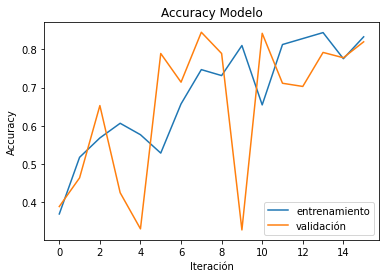

In [35]:
# Gráfica de la métrica de precisión
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Modelo')
plt.ylabel('Accuracy')
plt.xlabel('Iteración')
plt.legend(['entrenamiento', 'validación'], loc='lower right')
plt.show()

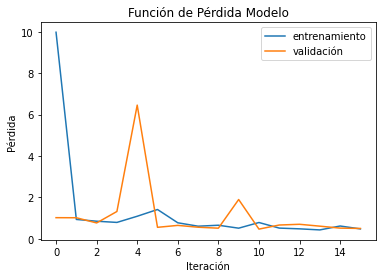

In [36]:
# Gráfica de la función de pérdida
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Función de Pérdida Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Iteración')
plt.legend(['entrenamiento', 'validación'], loc='upper right')
plt.show()

In [37]:
# Load Model
model_loaded = load_model("/content/Ciencia_Datos/EjemploCNN/model_jupyter_VGG16.h5")

In [38]:
step_size_test=test_generator.n/test_generator.batch_size
result_evaluate =  model_loaded.evaluate_generator(test_generator,step_size_test,verbose=1)
print(result_evaluate)

Instructions for updating:
Please use Model.evaluate, which supports generators.
300/300 [==============================] - 3s 8ms/step - loss: 0.6089 - accuracy: 0.7467
[0.6089442372322083, 0.746666669845581]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


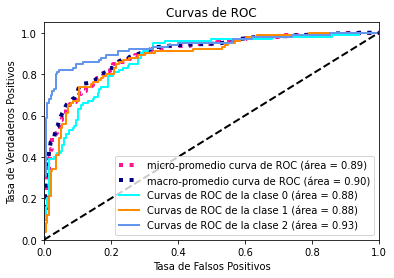

In [41]:
y_pred_prob =  model_loaded.predict_generator(test_generator, steps= step_size_test)
y_pred_classes = np.argmax(y_pred_prob, axis=1)
test_labels_one_hot = to_categorical(test_generator.classes)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_one_hot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels_one_hot.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot((fpr["micro"]), (tpr["micro"]),
         label='micro-promedio curva de ROC (área = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)


plt.plot(fpr["macro"], tpr["macro"],
         label='macro-promedio curva de ROC (área = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Curvas de ROC de la clase {0} (área = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas de ROC')
plt.legend(loc="lower right")
plt.show()

In [42]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_generator.classes, y_pred_classes)
print('Accuracy: %f' % accuracy)

Accuracy: 0.726667


In [43]:
# precision tp / (tp + fp)
precision = precision_score(test_generator.classes, y_pred_classes, average = 'macro')
print('Precision:', precision)

Precision: 0.740855927698033


In [44]:
# recall: tp / (tp + fn)
recall = recall_score(test_generator.classes, y_pred_classes, average = 'macro')
print('Recall: %f' % recall)

Recall: 0.726667


In [45]:
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_generator.classes, y_pred_classes, average = 'macro')
print('F1 score: %f' % f1)

F1 score: 0.721144


In [46]:
# kappa
kappa = cohen_kappa_score(test_generator.classes, y_pred_classes)
print('Cohens kappa: %f' % kappa)

Cohens kappa: 0.590000


In [47]:
# confusion matrix
matrix = confusion_matrix(test_generator.classes, y_pred_classes)
print(matrix)

[[78  6 16]
 [34 54 12]
 [ 8  6 86]]


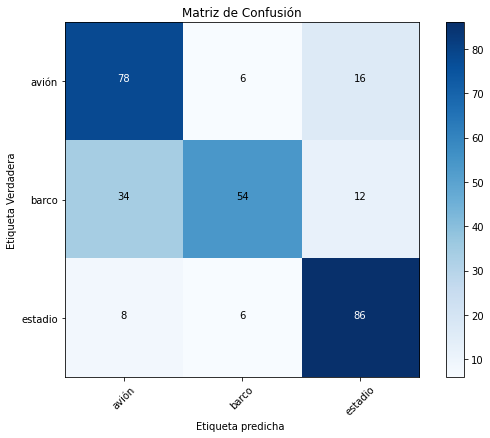

In [48]:
cmap = plt.get_cmap('Blues')
plt.figure(figsize=(8, 6))
plt.imshow(matrix, interpolation='nearest',cmap=cmap)
plt.title("Matriz de Confusión")
plt.colorbar()
target_names = ['avión', 'barco', 'estadio']

if target_names is not None:
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)



thresh = matrix.max() / 1.5
matrix.max() / 2
for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, "{:,}".format(matrix[i, j]),horizontalalignment="center",color="white" if matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta predicha ')
plt.show()